#### This notebook runs experiments with a stochastic (white noise) forcing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
from scipy.optimize import curve_fit
import scipy.stats as stats

## The model

Consider the following modification to the heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0(t))\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

_Make a note of the initial and boundary conditions._

We will write a forward-time, central-space finite difference scheme for this initial-boundary value problem. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [2]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)

z_m = 50.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

mu = 1/(50 * 365 * 86400) # Deep ocean restoring time scale
gamma = 1/(0.7 * 365 * 86400) # Surface restoring time scale (to be determined through my least squares regression)
kappa = 1e-6 # Diffusivity, m/s^2

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
#         OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = np.mean(T[:, i]) # This is for average temperature
        
    return OHC    



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1)
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
            
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T[m, 0]))) * np.heaviside(z_m - z, 0)[m]  \
            - dt * mu * (T[m, n] - T[m, 0]) * Hdeep[m]
            
            # np.heaviside(z_m - z, 0): 1 above z = z_m, 0 elsewhere
            # np.heaviside(z - z_d, 1): 1 below z = z_d, 0 elsewhere
            
        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

### Define forcings

In [17]:
years = 150
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

np.random.seed(3)

# def wiener(N, sig, d):
#     times = np.linspace(0, 1, N + 1)
#     dT = times[1] - times[0]
#     dW = np.sqrt(dT) * np.random.normal(0.0, sig, size = (N, d))
#     W0 = np.zeros(shape = (1, d))
#     W = np.concatenate((W0, np.cumsum(dW, axis = 0)), axis = 0)
#     return W

def white_noise(N, sig):
    f = np.append(0, np.random.normal(0.0, sig, size = N)) # dW/dt
    return f

sig = 0.5 # (so that 2*sig = 1, and 95% of values are within \pm 1)
stochastic_forcing = white_noise(N, sig)

-0.01902296665193637
0.49703447521826677


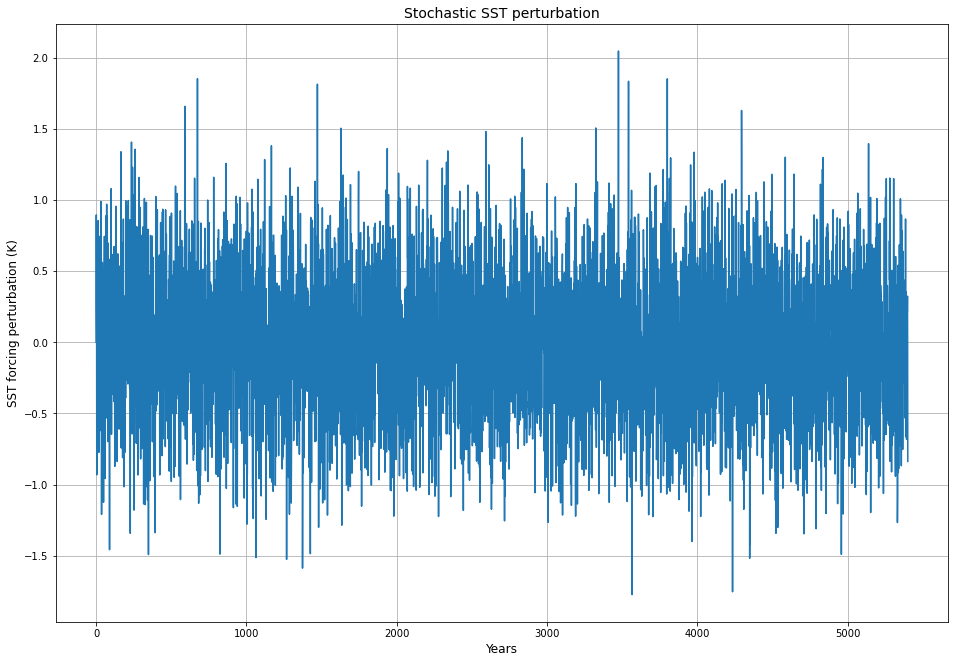

In [18]:
plt.figure(figsize=(16,11))
plt.plot(stochastic_forcing[:])
plt.grid()
plt.xlabel('Years', fontsize=12)
plt.ylabel('SST forcing perturbation (K)', fontsize=12)
plt.title('Stochastic SST perturbation', fontsize=14)


print(np.mean(stochastic_forcing))
print(np.std(stochastic_forcing))
plt.show()

### Run all stochastic forcings and calculate statistics

In [19]:
# Control

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q_cont, T0_cont, years)

# Variable forcing

T_stoc = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, 8 * stochastic_forcing, stochastic_forcing, years)

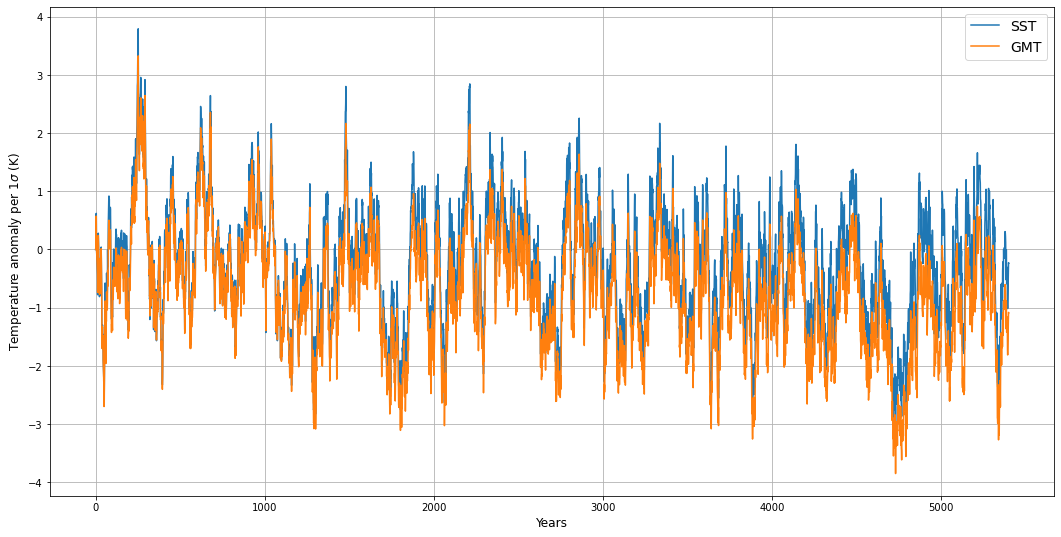

In [23]:
plt.figure(figsize=(18,9))

T_anom = T_stoc - T_cont
SST_anom = T_anom[0,:]
GAT_anom = OHC(T_anom)

plt.plot(SST_anom/np.std(SST_anom), label='SST')
plt.plot(GAT_anom/np.std(GAT_anom), label='GMT')
plt.ylabel('Temperature anomaly per 1$\sigma$ (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.grid()
plt.legend(fontsize=14)

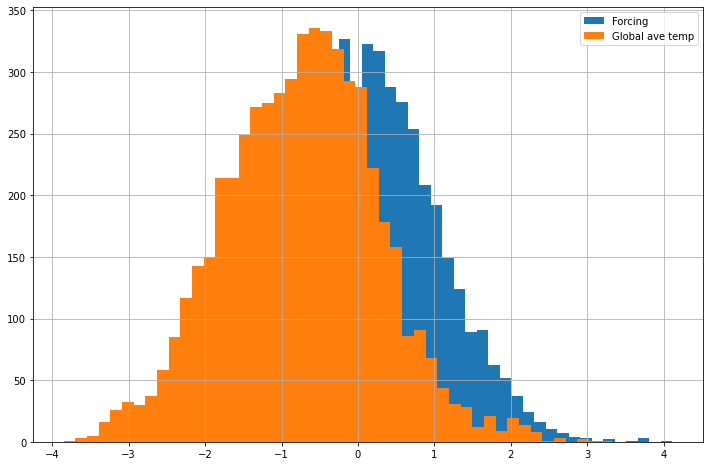

In [24]:
plt.figure(figsize=(12,8))
plt.hist(stochastic_forcing/np.std(stochastic_forcing), bins='auto', label='Forcing')
plt.hist(GAT_anom/np.std(GAT_anom), bins='auto', label='Global ave temp')
plt.grid()
plt.legend()

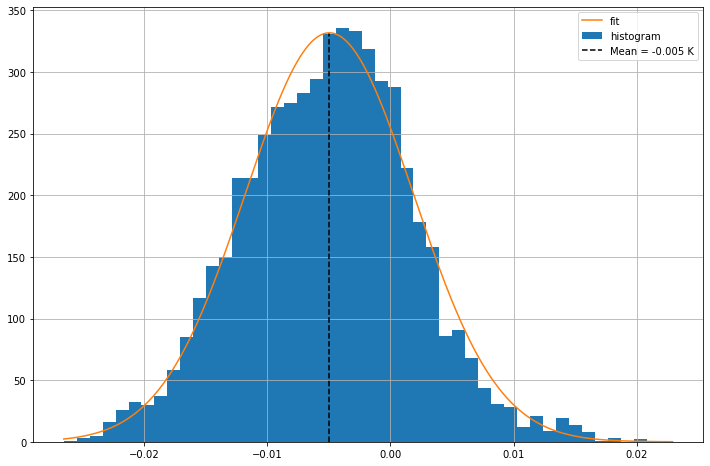

In [25]:
plt.figure(figsize=(12,8))

def gaussian_fit(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))
    
bin_heights, bin_borders, _ = plt.hist(GAT_anom, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian_fit, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
gaussian = gaussian_fit(x_interval_for_fit, *popt)
plt.plot(x_interval_for_fit, gaussian, label='fit')
plt.vlines(popt[0], 0, np.max(gaussian), color='k',linestyle='--', label=f'Mean = {np.round(popt[0], 4)} K')
plt.legend()
plt.grid()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


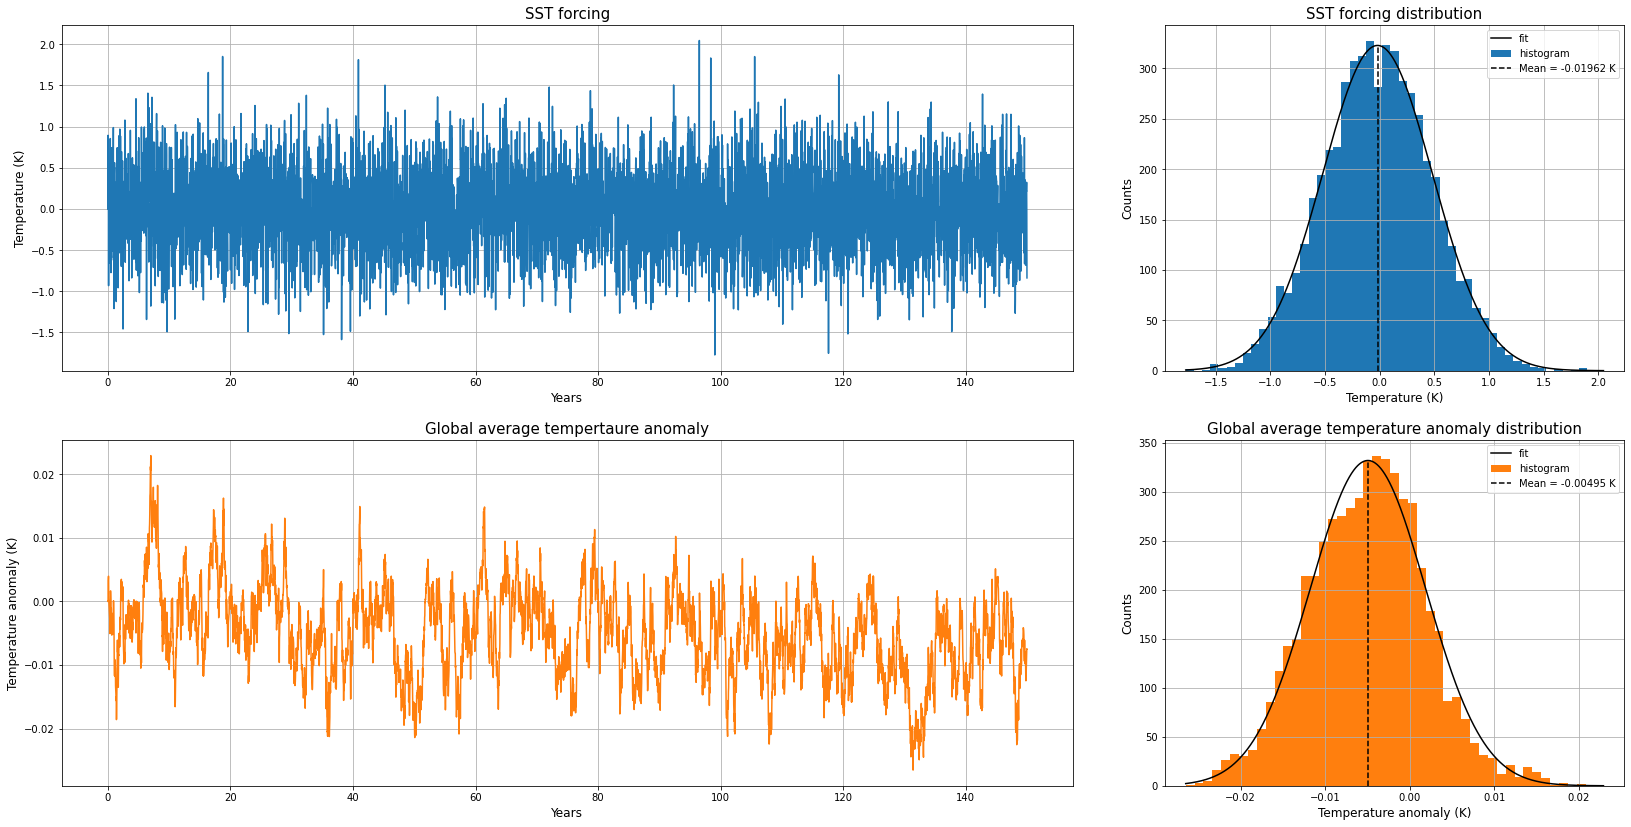

In [26]:
fig = plt.figure(constrained_layout=True, figsize=(28,14))
gs = fig.add_gridspec(2, 3)

# SST forcing time series
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_title('SST forcing', fontsize=15)
ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Temperature (K)', fontsize=12)
ax1.grid()
ax1.plot(t/360, stochastic_forcing, color='C0')

# SST forcing distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.set_title('SST forcing distribution', fontsize=15)
ax2.set_xlabel('Temperature (K)', fontsize=12)
ax2.set_ylabel('Counts', fontsize=12)
ax2.grid()
bin_heights, bin_borders, _ = plt.hist(stochastic_forcing, bins='auto', label='histogram', color='C0')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian_fit, bin_centers, bin_heights, p0=[1., 0., 1.])
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
normal = gaussian_fit(x_interval_for_fit, *popt)
ax2.plot(x_interval_for_fit, normal, label='fit', color='k')
ax2.vlines(popt[0], 0, np.max(normal), color='k',linestyle='--', label=f'Mean = {np.round(popt[0], 5)} K')
ax2.legend()

# Global average temperature anomaly time series
ax3 = fig.add_subplot(gs[1, 0:2])
ax3.set_title('Global average tempertaure anomaly', fontsize=15)
ax3.set_xlabel('Years', fontsize=12)
ax3.set_ylabel('Temperature anomaly (K)', fontsize=12)
ax3.grid()
ax3.plot(t/360, GAT_anom, color='C1')

# Global average temperature anomaly distribution
ax4 = fig.add_subplot(gs[1, 2])
ax4.set_title('Global average temperature anomaly distribution', fontsize=15)
ax4.set_xlabel('Temperature anomaly (K)', fontsize=12)
ax4.set_ylabel('Counts', fontsize=12)
ax4.grid()
bin_heights, bin_borders, _ = plt.hist(GAT_anom, bins='auto', label='histogram', color='C1')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian_fit, bin_centers, bin_heights, p0=[1., 0., 1.])
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
normal = gaussian_fit(x_interval_for_fit, *popt)
ax4.plot(x_interval_for_fit, normal, label='fit', color='k')
ax4.vlines(popt[0], 0, np.max(normal), color='k',linestyle='--', label=f'Mean = {np.round(popt[0], 5)} K')
ax4.legend()
# plt.savefig('stochastic_global_ave_temp.jpg')

In [56]:
# Control

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q_cont, T0_cont, years)

# Variable forcing

GAT_stoc_anom = np.empty(shape = (years, stochastic_forcing.shape[1]))
SST_stoc_anom = np.empty(shape = (years, stochastic_forcing.shape[1]))

for i in range(stochastic_forcing.shape[1]):
    T_stoc = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, 8 * stochastic_forcing[:, i], stochastic_forcing[:, i], years)
    T_anom = T_stoc - T_cont
    
    GAT_stoc_anom[:, i] = np.array([np.mean(T_anom[:, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(years)])
    SST_stoc_anom[:, i] = np.array([np.mean(T_anom[0, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(years)])

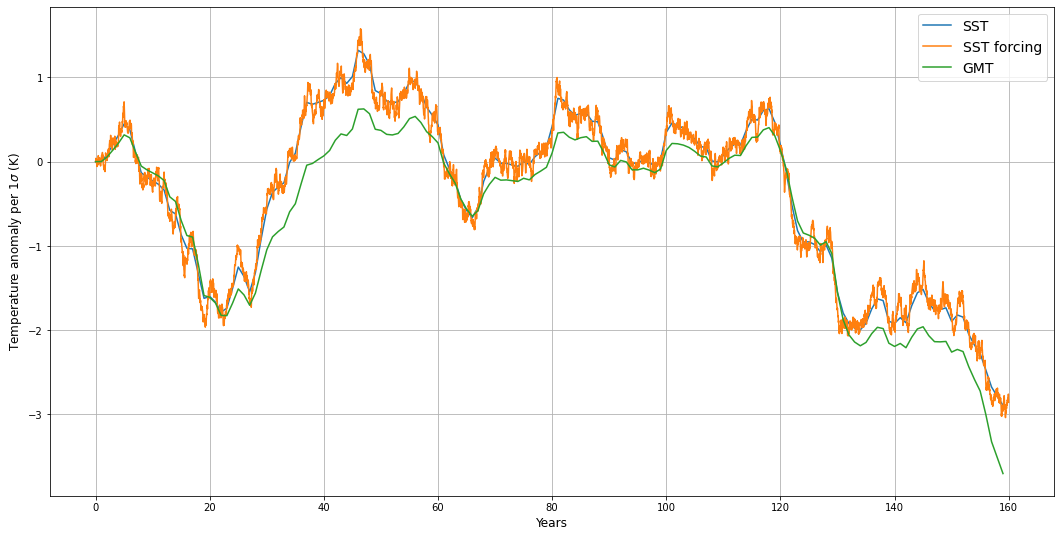

In [197]:
realisation = 8

plt.figure(figsize=(18,9))
plt.plot(SST_stoc_anom[:, realisation]/np.std(SST_stoc_anom[:, realisation]), label='SST')
plt.plot(t/360, stochastic_forcing[:, realisation]/np.std(stochastic_forcing[:, realisation]), label='SST forcing')
plt.plot(GAT_stoc_anom[:, realisation]/np.std(GAT_stoc_anom[:, realisation]), label='GMT')
plt.ylabel('Temperature anomaly per 1$\sigma$ (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.grid()
plt.legend(fontsize=14)

Mean of ensemble average forcing is 0.0041886580480940076 K
Mean of ensemble average SST is 0.013118235277236595 K
Mean of ensemble average mean temperature is -0.01723620475465279 K


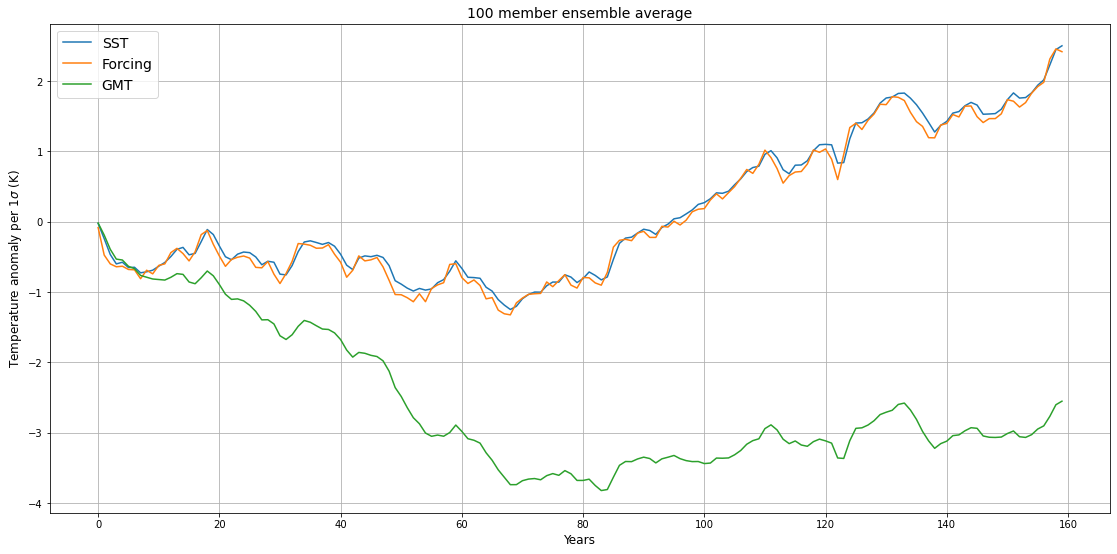

In [189]:
### Caluclate statistics

GAT_stoc_anom_ensemble_ave = np.mean(GAT_stoc_anom, axis = 1)
GAT_stoc_anom_ensemble_ave_mean = np.mean(GAT_stoc_anom_ensemble_ave)
GAT_stoc_anom_ensemble_ave_std = np.std(GAT_stoc_anom_ensemble_ave)
GAT_stoc_anom_ensemble_ave_normed = (GAT_stoc_anom_ensemble_ave) / GAT_stoc_anom_ensemble_ave_std
GAT_stoc_anom_ensemble_ave_normed_mean = np.mean(GAT_stoc_anom_ensemble_ave_normed)

SST_stoc_anom_ensemble_ave = np.mean(SST_stoc_anom, axis = 1)
SST_stoc_anom_ensemble_ave_mean = np.mean(SST_stoc_anom_ensemble_ave)
SST_stoc_anom_ensemble_ave_std = np.std(SST_stoc_anom_ensemble_ave)
SST_stoc_anom_ensemble_ave_normed = (SST_stoc_anom_ensemble_ave) / SST_stoc_anom_ensemble_ave_std
SST_stoc_anom_ensemble_ave_normed_mean = np.mean(SST_stoc_anom_ensemble_ave_normed)

stochastic_forcing_yrly = np.array([np.mean(stochastic_forcing[36 * n + 1 : 36 + 36 * n + 1, :], axis = 0) for n in range(years)])
stochastic_forcing_yrly_ensemble_ave = np.mean(stochastic_forcing_yrly, axis = 1)
stochastic_forcing_yrly_ensemble_ave_mean = np.mean(stochastic_forcing_yrly_ensemble_ave)
stochastic_forcing_yrly_ensemble_ave_std = np.std(stochastic_forcing_yrly_ensemble_ave)
stochastic_forcing_yrly_ensemble_ave_normed = (stochastic_forcing_yrly_ensemble_ave) / stochastic_forcing_yrly_ensemble_ave_std
stochastic_forcing_yrly_ensemble_ave_normed_mean = np.mean(stochastic_forcing_yrly_ensemble_ave_normed)

# plot

plt.figure(figsize=(19,9))
plt.plot(SST_stoc_anom_ensemble_ave_normed, label = 'SST')#, mean = {}'.format(np.round(SST_stoc_anom_ensemble_ave_normed_mean, 4)))
plt.plot(stochastic_forcing_yrly_ensemble_ave_normed, label = 'Forcing')#, mean = {}'.format(np.round(stochastic_forcing_yrly_ensemble_ave_normed_mean, 4)))
plt.plot(GAT_stoc_anom_ensemble_ave_normed, label = 'GMT')#, mean = {}'.format(np.round(GAT_stoc_anom_ensemble_ave_normed_mean, 4)))

plt.ylabel('Temperature anomaly per 1$\sigma$ (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.title('100 member ensemble average', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

print('Mean of ensemble average forcing is ' + str(stochastic_forcing_yrly_ensemble_ave_mean) + ' K')
print('Mean of ensemble average SST is ' + str(SST_stoc_anom_ensemble_ave_mean) + ' K')
print('Mean of ensemble average mean temperature is ' + str(GAT_stoc_anom_ensemble_ave_mean) + ' K')

plt.show()

Mean of ensemble average forcing is 0.0041886580480940076 K
Mean of ensemble average mean temperature is -0.01723620475465279 K


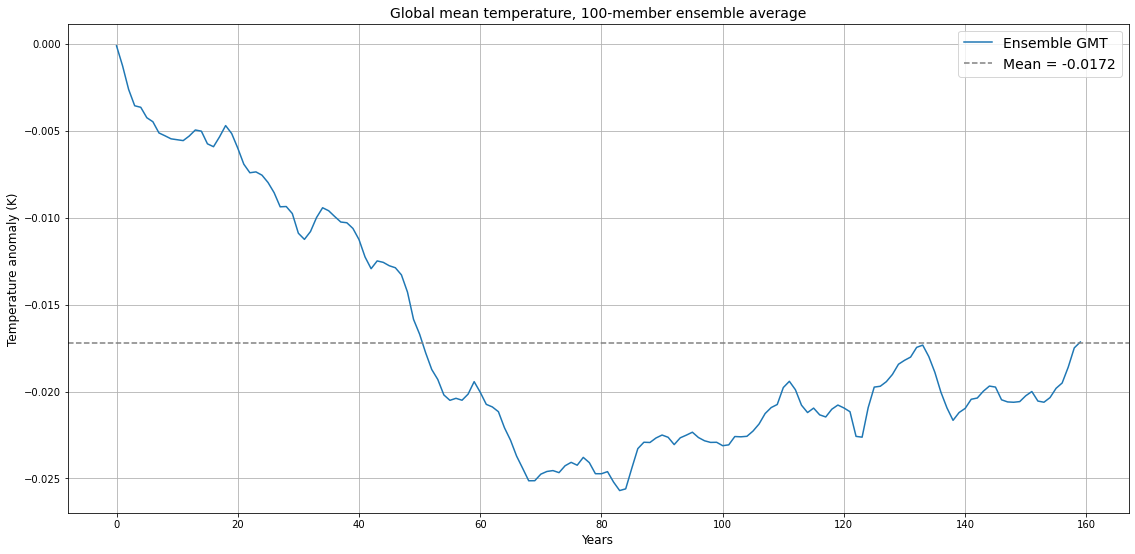

In [182]:
print('Mean of ensemble average forcing is ' + str(stochastic_forcing_yrly_ensemble_ave_mean) + ' K')
print('Mean of ensemble average mean temperature is ' + str(GAT_stoc_anom_ensemble_ave_mean) + ' K')

plt.figure(figsize=(19,9))
plt.plot()
plt.plot(GAT_stoc_anom_ensemble_ave, label='Ensemble GMT')
#plt.plot(stochastic_forcing_yrly_ensemble_ave, label='Ensemble SST forcing')
mean = GAT_stoc_anom_ensemble_ave_mean
plt.axhline(y = mean, color='gray', linestyle='--', \
            label = 'Mean = {}'.format(np.round(mean, 4)))
plt.title('Global mean temperature, 100-member ensemble average', fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.grid()
plt.legend(fontsize=14)
plt.show()

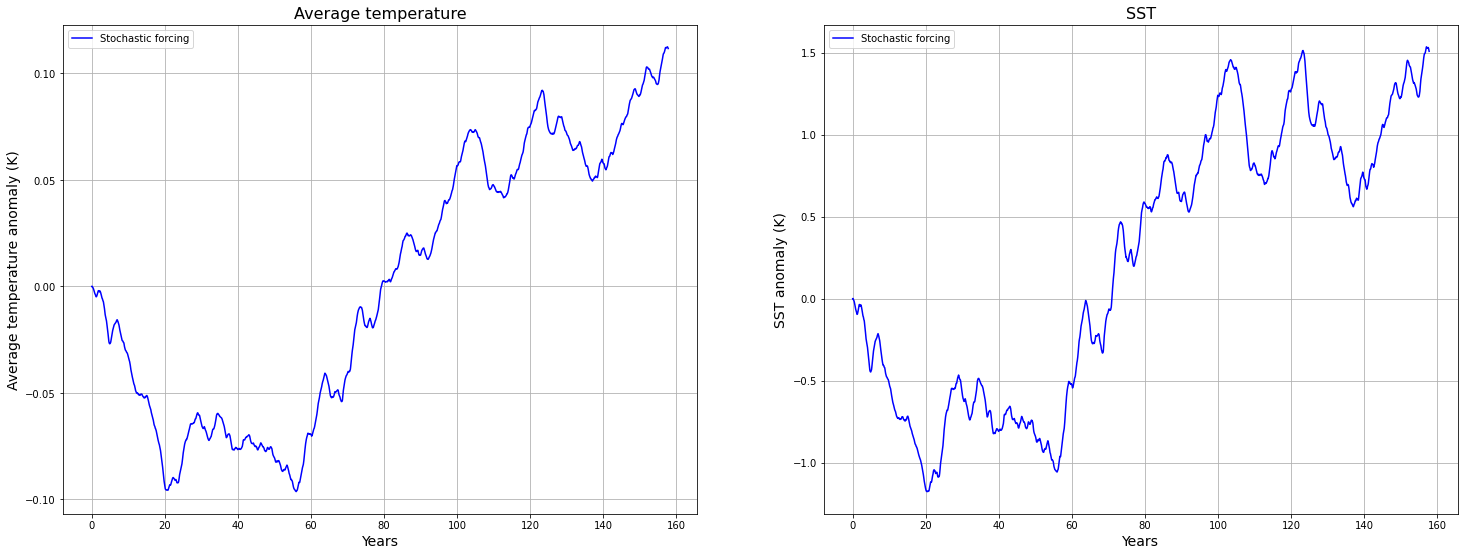

In [49]:
#### Plot

days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

#Calculate ocean heat content
GAT_cont = OHC(T_cont)
GAT_stochastic = OHC(T_stochastic)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

# Ocean heat content over time

axs[0].plot(time_years, GAT_stochastic - GAT_cont, color='b', label='Stochastic forcing')
axs[0].grid()
axs[0].set_title('Average temperature', fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

# SST over time
axs[1].plot(time_years, T_stochastic[0, :] - T_cont[0, :], color='b',label='Stochastic forcing')
axs[1].grid()
axs[1].set_title('SST', fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()
#plt.savefig('temp_diagnostics_access_strat.jpg')

plt.figure(figsize=(14,11))
plt.plot(stochastic_forcing[:, 31])
plt.grid()
plt.show()

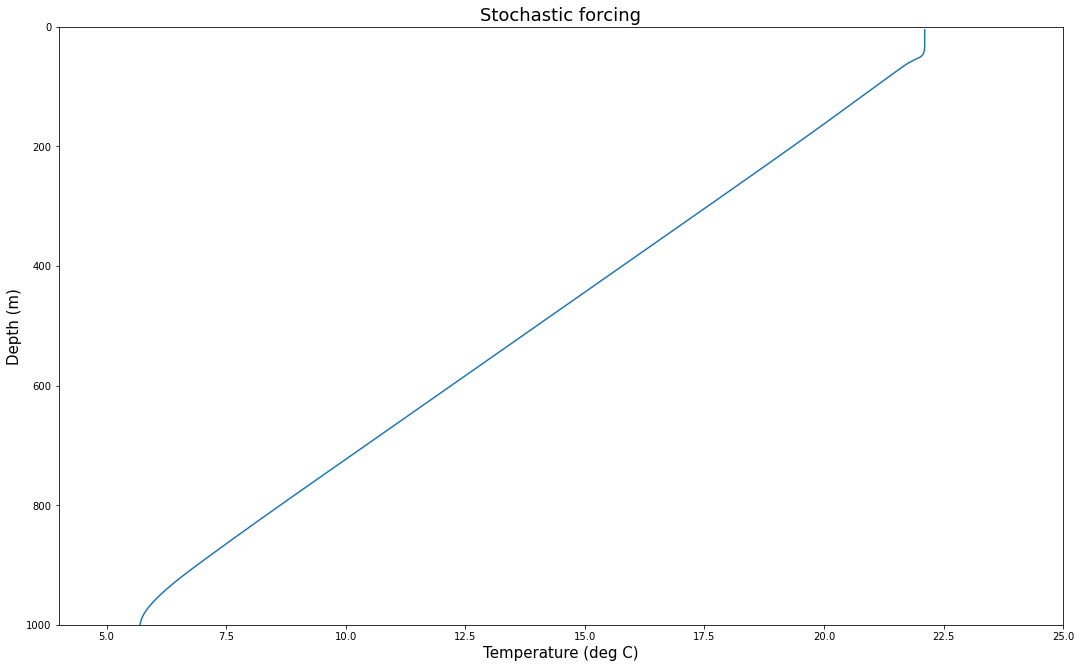

In [69]:
#Animate the forcing

expt = T_stoc

fig = plt.figure(figsize=(18,11))
ax = plt.axes(xlim=(4, 25), ylim=(z[0], z[-1]))

line, = plt.plot([], [])

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(expt[:, i], z[1 : ])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(expt[0, :]), interval=50, blit=True)

title = 'Stochastic forcing'

ax.set_title(title, fontsize = 18)
ax.set_xlabel('Temperature (deg C)', fontsize = 15)
ax.set_ylabel('Depth (m)', fontsize = 15)
ax.invert_yaxis()

anim.save('stochastic_forcing.mp4')